# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad, jacobian

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [3]:
# import numpy as np
from itertools import combinations as combi

# Definitions

In [5]:
def msqrt_derivs(cov, n=100000, scale=None, tol=0.5e-15):
    """Calculate the square root of a symmetric matrix as well as the
    derivatives of the square root with respect to individual coefficients
    in cov.
    The calculation is based on a series expansion assuming that ||cov|| < 1
    Parameters
    ----------
    cov: np.ndarray[float] (m ,m)
        symmetric matrix such that ||cov|| <= 1
    n: integer (optional, default=100000)
        number of terms in the expansion
    scale: float (optional, default=None)
        a scaling factor < 1 that be used to ensure convergence
    """
    cov = np.array(cov, copy=True)
    m = cov.shape[-1]
    nderivs = int(m * (m - 1) / 2)
    scale = float(2 * m) if scale is None else scale
    sq_scale = np.sqrt(scale)
    cov /= scale
    v = np.eye(m, dtype=np.float64)
    prev_v = np.array(v, copy=True)
    a = cov - v
    out = v.copy()
    # for derivative calculation
    out_deriv = np.zeros((nderivs, m, m), dtype=np.float64)
    J = np.zeros((nderivs, m, m), dtype=np.float64)
    for k, (row, col) in enumerate(combi(range(m), 2)):
        J[k, [row, col], [col, row]] = 1.0
    w = np.array(J, copy=True)
    # convergence parameters
    step = 50  # test convergence every `step`
    prev_out = np.array(out, copy=True)
    if n == 0:
        return out, out_deriv
    for k in range(1, n+1):
        c = (3. - 2 * k)/(2. * k)
        v = np.einsum(',ij,jk->ik', c, v, a)
        if k > 1:
            w = np.einsum(
                ',uij,jk->uik', c, w, a)
            np.add(
                w, np.einsum(',ij,ujk->uik', c, prev_v, J), out=w)
        else:
            w *= c
        out += v
        out_deriv += w
        if k % step == 0:
            # check for convergence
            norm = max(np.abs(out - prev_out).ravel())
            if norm < tol:
                break
            prev_out = np.array(out, copy=True)
        prev_v = np.array(v, copy=True)

    return sq_scale * out, out_deriv / sq_scale

# Edited by FS to be used with autograd: changed a few assignments, removed the
# calculation of the derivarives
def msqrt_derivs_fs(cov, n=100000, scale=None, tol=0.5e-15):
    """Calculate the square root of a symmetric matrix as well as the
    derivatives of the square root with respect to individual coefficients
    in cov.
    The calculation is based on a series expansion assuming that ||cov|| < 1
    Parameters
    ----------
    cov: np.ndarray[float] (m ,m)
        symmetric matrix such that ||cov|| <= 1
    n: integer (optional, default=100000)
        number of terms in the expansion
    scale: float (optional, default=None)
        a scaling factor < 1 that be used to ensure convergence
    """
    cov = np.array(cov, copy=True)
    m = cov.shape[-1]
    nderivs = int(m * (m - 1) / 2)
    scale = float(2 * m) if scale is None else scale
    sq_scale = np.sqrt(scale)
    cov /= scale
    v = np.eye(m, dtype=np.float64)
    prev_v = np.array(v, copy=True)
    a = cov - v
    out = v.copy()
    # for derivative calculation
    out_deriv = np.zeros((nderivs, m, m), dtype=np.float64)
    J = np.zeros((nderivs, m, m), dtype=np.float64)
    for k, (row, col) in enumerate(combi(range(m), 2)):
        J[k, [row, col], [col, row]] = 1.0
    w = np.array(J, copy=True)
    # convergence parameters
    step = 50  # test convergence every `step`
    prev_out = np.array(out, copy=True)
    if n == 0:
        return out, out_deriv
    for k in range(1, n+1):
        c = (3. - 2 * k)/(2. * k)
        v = np.einsum(',ij,jk->ik', c, v, a)
#         if k > 1:
#             w = np.einsum(
#                 ',uij,jk->uik', c, w, a)
#             w = w + np.einsum(',ij,ujk->uik', c, prev_v, J)  # np.add(w, np.einsum(',ij,ujk->uik', c, prev_v, J), out=w)
#         else:
#             w = w * c  # w *= c
        out = out + v  # out += v
#         out_deriv = out_deriv + w  # out_deriv += w
#         if k % step == 0:
#             # check for convergence
#             norm = max(np.abs(out - prev_out).ravel())
#             if norm < tol:
#                 break
#             prev_out = np.array(out, copy=True)
#         prev_v = np.array(v, copy=True)

    return sq_scale * out  # , out_deriv / sq_scale

def msqrt_only(args):
    
    cov = make_mat_2d(args)
    
    out = msqrt_derivs_fs(cov)
    
    return out

def make_mat_2d(args):
    
    vol1, vol2, corr = args
    
    mat = np.array([[vol1 * vol1, corr * vol1 * vol2], [corr * vol1 * vol2, vol2 * vol2]])
    
    return mat

def my_cholesky_2d_vec(args):

    return np.linalg.cholesky(make_mat_2d(args))

def my_cholesky_2d_tuple(args):

    b = np.linalg.cholesky(make_mat_2d(args))
    
    b = tuple([tuple(_) for _ in b])
    
    return b

# Example: n=2 full covariance (AI $\neq$ autograd = WL)

In [32]:
params = np.array([0.22, 0.3, -0.98])

mat = make_mat_2d(params)

In [33]:
mat

array([[ 0.0484 , -0.06468],
       [-0.06468,  0.09   ]])

In [34]:
jac_mat = jacobian(make_mat_2d)(params)

In [35]:
jac_mat[:, :, 0]

array([[ 0.44 , -0.294],
       [-0.294,  0.   ]])

In [36]:
jac_mat[:, :, 1]

array([[ 0.    , -0.2156],
       [-0.2156,  0.6   ]])

In [37]:
jac_mat[:, :, 2]

array([[ 0.   ,  0.066],
       [ 0.066,  0.   ]])

In [40]:
out, derivs = msqrt_derivs(mat)

In [41]:
out

array([[ 0.15163861, -0.15939175],
       [-0.15939175,  0.25415403]])

In [42]:
derivs[0]

array([[ 7.60093716,  7.23121223],
       [ 7.23121223,  4.53502782]])

In [43]:
out_fs = msqrt_derivs_fs(mat)
out_fs

array([[ 0.15163861, -0.15939175],
       [-0.15939175,  0.25415403]])

In [44]:
msqrt_only(params)

array([[ 0.15163861, -0.15939175],
       [-0.15939175,  0.25415403]])

In [45]:
d_fs = jacobian(msqrt_only)(params)

In [46]:
d_fs[:,:,0]

array([[ 0.97384673, -0.45377022],
       [-0.45377022, -0.2845803 ]])

In [47]:
d_fs[:,:,1]

array([[-0.20869222, -0.19854101],
       [-0.19854101,  1.05587231]])

In [48]:
d_fs[:,:,2]

array([[ 0.50166185,  0.47726001],
       [ 0.47726001,  0.29931184]])

In [49]:
d_fs.shape

(2, 2, 3)

# Example: n=2 pure correlation (AI = autograd = WL)

In [5]:
params = np.array([1., 1., -0.98])

mat = make_mat_2d(params)

In [6]:
mat

array([[ 1.  , -0.98],
       [-0.98,  1.  ]])

In [7]:
jac_mat = jacobian(make_mat_2d)(params)

In [8]:
jac_mat[:, :, 0]

array([[ 2.  , -0.98],
       [-0.98,  0.  ]])

In [9]:
jac_mat[:, :, 1]

array([[ 0.  , -0.98],
       [-0.98,  2.  ]])

In [10]:
jac_mat[:, :, 2]

array([[ 0.,  1.],
       [ 1.,  0.]])

In [17]:
out, derivs = msqrt_derivs(mat)

In [18]:
out

array([[ 0.77427304, -0.63285169],
       [-0.63285169,  0.77427304]])

In [19]:
derivs[0]

array([[ 1.59009969,  1.94543422],
       [ 1.94543422,  1.59009969]])

In [20]:
out_fs = msqrt_derivs_fs(mat)
out_fs

array([[ 0.77427304, -0.63285169],
       [-0.63285169,  0.77427304]])

In [21]:
msqrt_only(params)

array([[ 0.77427304, -0.63285169],
       [-0.63285169,  0.77427304]])

In [22]:
d_fs = jacobian(msqrt_only)(params)

In [23]:
d_fs[:, :, 0]

array([[ 1.03290355, -0.31642584],
       [-0.31642584, -0.25863051]])

In [24]:
d_fs[:, :, 1]

array([[-0.25863051, -0.31642584],
       [-0.31642584,  1.03290355]])

In [25]:
d_fs[:, :, 2]

array([[ 1.59009969,  1.94543422],
       [ 1.94543422,  1.59009969]])

In [26]:
shift = 1e-5

params_shifted = np.array([1., 1., -0.98 + shift])

In [27]:
mat_shifted = make_mat_2d(params_shifted)

In [28]:
mat_shifted

array([[ 1.     , -0.97999],
       [-0.97999,  1.     ]])

In [29]:
out_shifted, d_shifted = msqrt_derivs(mat_shifted)

In [30]:
out_shifted

array([[ 0.77428894, -0.63283223],
       [-0.63283223,  0.77428894]])

In [31]:
(out_shifted - out) / shift

array([[ 1.58987855,  1.94521353],
       [ 1.94521353,  1.58987855]])

# Example n=4 pure correlation

Using a correlation matrix, depending on a parameter $t \in [-\pi, \pi]$, which is positive semi-definite by construction. The seed refers to the specific way the parameter $t$ is chosen. 

Not sure how to compare approaches. Below the comparison is between the norms of the derivative of the square root matrices. 

## seed=130

![](corr_130.png)

In [6]:
def corr_mat_130(t):

    out = np.array([ [ np.cos(1)**2+np.cos(1)**2*np.sin(1)**2+np.cos(1)**2*np.sin(1)**4+np.sin(1)**6, np.cos(1)**2+-1*np.cos(1)**2*np.sin(1)**2+np.cos(1)*np.cos(0.95+-0.97*1+t)*np.sin(1)**4+np.sin(1)**5*np.sin(0.95+-0.97*1+t), np.cos(1)**2+-1*np.cos(1)*np.cos(t)*np.sin(1)**2+-1*np.cos(1)*np.cos(t)*np.sin(1)**3*np.sin(t)+np.sin(1)**4*np.sin(t)**2, np.cos(1)**2+np.cos(1)**2*np.sin(1)**2+-1*np.cos(1)**2*np.sin(1)**4+-1*np.sin(1)**6 ], [ np.cos(1)**2+-1*np.cos(1)**2*np.sin(1)**2+np.cos(1)*np.cos(0.95+-0.97*1+t)*np.sin(1)**4+np.sin(1)**5*np.sin(0.95+-0.97*1+t), np.cos(1)**2+np.cos(1)**2*np.sin(1)**2+np.cos(0.95+-0.97*1+t)**2*np.sin(1)**4+np.sin(1)**4*np.sin(0.95+-0.97*1+t)**2, np.cos(1)**2+np.cos(1)*np.cos(t)*np.sin(1)**2+-1*np.cos(t)*np.cos(0.95+-0.97*1+t)*np.sin(1)**3*np.sin(t)+np.sin(1)**3*np.sin(t)**2*np.sin(0.95+-0.97*1+t), np.cos(1)**2+-1*np.cos(1)**2*np.sin(1)**2+-1*np.cos(1)*np.cos(0.95+-0.97*1+t)*np.sin(1)**4+-1*np.sin(1)**5*np.sin(0.95+-0.97*1+t) ], [ np.cos(1)**2+-1*np.cos(1)*np.cos(t)*np.sin(1)**2+-1*np.cos(1)*np.cos(t)*np.sin(1)**3*np.sin(t)+np.sin(1)**4*np.sin(t)**2, np.cos(1)**2+np.cos(1)*np.cos(t)*np.sin(1)**2+-1*np.cos(t)*np.cos(0.95+-0.97*1+t)*np.sin(1)**3*np.sin(t)+np.sin(1)**3*np.sin(t)**2*np.sin(0.95+-0.97*1+t), np.cos(1)**2+np.cos(t)**2*np.sin(1)**2+np.cos(t)**2*np.sin(1)**2*np.sin(t)**2+np.sin(1)**2*np.sin(t)**4, np.cos(1)**2+-1*np.cos(1)*np.cos(t)*np.sin(1)**2+np.cos(1)*np.cos(t)*np.sin(1)**3*np.sin(t)+-1*np.sin(1)**4*np.sin(t)**2 ], [ np.cos(1)**2+np.cos(1)**2*np.sin(1)**2+-1*np.cos(1)**2*np.sin(1)**4+-1*np.sin(1)**6, np.cos(1)**2+-1*np.cos(1)**2*np.sin(1)**2+-1*np.cos(1)*np.cos(0.95+-0.97*1+t)*np.sin(1)**4+-1*np.sin(1)**5*np.sin(0.95+-0.97*1+t), np.cos(1)**2+-1*np.cos(1)*np.cos(t)*np.sin(1)**2+np.cos(1)*np.cos(t)*np.sin(1)**3*np.sin(t)+-1*np.sin(1)**4*np.sin(t)**2, np.cos(1)**2+np.cos(1)**2*np.sin(1)**2+np.cos(1)**2*np.sin(1)**4+np.sin(1)**6 ] ])
    return out


In [7]:
def b_130(t):
    
    return np.linalg.cholesky(corr_mat_130(t))

In [8]:
def cont_130(t):
    
    return np.linalg.norm(b_130(t))

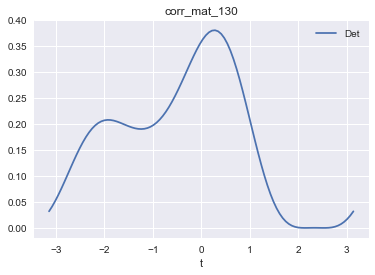

In [9]:
plt.figure()

x_data = np.linspace(-np.pi, np.pi, 100)
y_data = [np.linalg.det(corr_mat_130(_)) for _ in x_data]

plt.plot(x_data, y_data)
plt.xlabel('t')
plt.legend(['Det'])
plt.title('corr_mat_130')
plt.show()

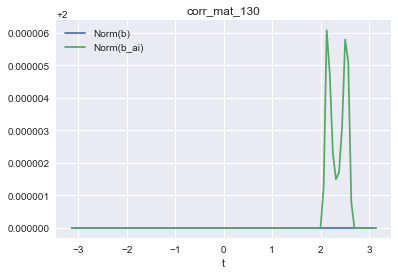

In [37]:
plt.figure()

x_data = np.linspace(-np.pi, np.pi, 100)
y_data = [np.linalg.norm(np.linalg.cholesky(corr_mat_130(_))) for _ in x_data]

x_data_ai = np.linspace(-np.pi, np.pi, 100)
y_data_ai = [np.linalg.norm(msqrt_derivs_fs(corr_mat_130(_))) for _ in x_data_ai]

plt.plot(x_data, y_data)
plt.plot(x_data_ai, y_data_ai)
plt.xlabel('t')
plt.legend(['Norm(b)', 'Norm(b_ai)'])
plt.title('corr_mat_130')
plt.show()

This shows the norm of the derivative of the square root matrix.
__The calculation of each derivative of 'msqrt' via autograd takes order 5 minutes__. 

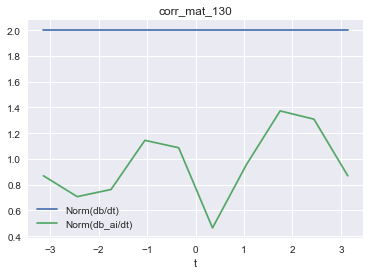

In [32]:
plt.figure()

x_data = np.linspace(-np.pi, np.pi, 100)
y_data = [cont_130(elementwise_grad(b_130)(_)) for _ in x_data]

x_data_ai = np.linspace(-np.pi, np.pi, 10)
y_data_ai = [np.linalg.norm(jacobian(lambda t: msqrt_derivs_fs(corr_mat_130(t)))(_)) for _ in x_data_ai]

plt.plot(x_data, y_data)
plt.plot(x_data_ai, y_data_ai)
plt.xlabel('t')
plt.legend(['Norm(db/dt)', 'Norm(db_ai/dt)'])
plt.title('corr_mat_130')
plt.show()

In [29]:
xxx = jacobian(lambda t: msqrt_derivs_fs(corr_mat_130(t)))(-np.pi)

In [31]:
np.linalg.norm(xxx)

0.86960212168369799